# PROYECTO DE CONSOLIDACIÓN: APRENDIZAJE SUPERVISADO (GRUPO 1)

## [EJERCICIO 2]

La empresa está desarrollando una aplicación a modo TripAdvisor en la que los usuarios van a poder valorar una serie de restaurantes en base a su experiencia. Para que los restaurantes se adieran a la aplicación y quieran compartirla con sus clientes, estos desean saber, en base a sus características, que valoración pueden tener. Para ayudarles, hay que tratar de predecir la valoración (variable rate) que obtendría cada restaurante en base a las variables conocidas:

- name: Nombre del restaurante.
- online_order:¿Aceptan pedidos en línea? (Verdadero/Falso)
- book_table: ¿Podemos reservar mesa en el restaurante?
- rate: Valoración que dan los usuarios en la aplicación (variable objetivo).
- votes: Número de valoraciones realizadas a un restaurante.
- location: Ubicación del restaurante.
- rest_type: Tipo de restaurante.
- cuisines: Tipo de cocina.
- Cost2plate: Coste aproximado de dos platos.
- Type: Categoría del restaurante.

La empresa solicita el siguiente informe:
- a) Ver el número de restaurantes por cada una de las localizaciones.
- b) Conocer el número de restaurantes que permiten y no permiten pedidos online y aquellos que permiten reservar mesa.
- c) Queremos conocer, mediante una visualización, cual es la distribución de la valoracion de los usuarios en función de si el restaurante permite o no pedidos online.
- d) Queremos conocer, mediante una visualización, cual es la distribución de la valoracion de los usuarios en función de si el restaurante permite o no reservar mesa.
- e) ¿Cual de las dos variables analizadas en los apartados d y e crees que sería más determinante de cara a un modelo de Machine Learning? ¿Por qué?
- f) Realiza las transformaciones que creas necesarias en las variables, explicando cada una de ellas, de cara a crear un modelo de regresión que sea capaz de predecir la valoración de los usuarios.
- g) Aplica un modelo de Regresión de los vistos en clase para tratar de predecir la valoración de los usuarios. Trata de mejorar los resultados aplicando otros modelos. (Regresión Lineal Múltiple, Árboles de Regresión o Random Forest Regressor)
- h) Selecciona el mejor modelo basándote en la métrica del RMSE.

Deberás entrenar y validar el modelo seleccionado sobre el dataset "app_restaurantes.csv".

Deberás explicar todos los pasos que vayas dando en la resolución del problema.

# Importación de librerías

In [238]:
#Librerías principales
import pandas as pd
import numpy as np
from scipy import stats
import xgboost as xgb

#Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots           import make_subplots

#Sklearn: preprocesado
from sklearn.model_selection   import train_test_split
from sklearn.compose           import ColumnTransformer
from sklearn.preprocessing     import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing     import FunctionTransformer


#Sklearn: selección de características
from sklearn.feature_selection import chi2

#Sklearn: pipelines
from sklearn.pipeline          import make_pipeline, Pipeline

#Sklearn: modelos
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LogisticRegression
from sklearn.linear_model      import LinearRegression
from sklearn.svm               import SVC
from sklearn.naive_bayes       import GaussianNB
from sklearn.tree              import DecisionTreeRegressor
from xgboost.sklearn           import XGBRegressor

#Sklearn: Hiperparámetros
from sklearn.model_selection import GridSearchCV

#Sklearn: Ensembles
from xgboost                   import XGBClassifier


#Sklearn: evaluación
from sklearn.feature_selection import RFECV
from sklearn.metrics           import make_scorer
from sklearn.metrics           import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics           import mean_squared_error

#Otras librerías
import time
from geopy.geocoders import Nominatim

# 1. Análisis exploratorio

In [146]:
data = pd.read_csv("./datasets/app_restaurantes_clean.csv")

train = data.copy()
test = data.copy()

train = train[train["rate"].isna() == False]
test = test[test["rate"].isna() == True]

In [147]:
print(train.shape)
print(test.shape)

(41665, 11)
(10052, 11)


In [148]:
data.head()

Unnamed: 0                   name online_order book_table   rate  votes  \
0           0                  Jalsa          Yes        Yes  4.1/5    775   
1           1         Spice Elephant          Yes         No  4.1/5    787   
2           2        San Churro Cafe          Yes         No  3.8/5    918   
3           3  Addhuri Udupi Bhojana           No         No  3.7/5     88   
4           4          Grand Village           No         No  3.8/5    166   

       location            rest_type                        cuisines  \
0  Banashankari        Casual Dining  North Indian, Mughlai, Chinese   
1  Banashankari        Casual Dining     Chinese, North Indian, Thai   
2  Banashankari  Cafe, Casual Dining          Cafe, Mexican, Italian   
3  Banashankari          Quick Bites      South Indian, North Indian   
4  Basavanagudi        Casual Dining        North Indian, Rajasthani   

   Cost2plate    Type  
0       800.0  Buffet  
1       800.0  Buffet  
2       800.0  Buffet  
3       300.0  Buffet  
4       600.0  Buffet

In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    51717 non-null  int64  
 1   name          51717 non-null  object 
 2   online_order  51717 non-null  object 
 3   book_table    51717 non-null  object 
 4   rate          41665 non-null  object 
 5   votes         51717 non-null  int64  
 6   location      51696 non-null  object 
 7   rest_type     51490 non-null  object 
 8   cuisines      51672 non-null  object 
 9   Cost2plate    51371 non-null  float64
 10  Type          51717 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 4.3+ MB


In [150]:
pd.set_option('display.max_rows', None)

def calculate_nan_stats(df):
    """
    Muestra las estadísticas (número y porcentaje) de valores NaN por cola de un DF y el total.

    Args:
        df (DataFrame): DataFrame de Pandas.

    Return:
        Retorna un DF con index de colas del DF origen, 2 colas (nan_count, nan_percentage) y una row del total.

    """
  
    nan_count = df.isna().sum() # Numero de nan total por cola  
    nan_percentage = round(df.isna().mean(), 4) * 100 # Porcentaje de nan total por cola // .isna = .isnull  // = nan_percentage = df.isna().mean().round(4) * 100

    nan_df = pd.concat({'nan_count': nan_count, 'nan_percentage': nan_percentage}, axis = 1)


    nan_df.loc['Total'] = [nan_count.sum(), round(nan_percentage.mean(), 2)] # Nueva row con el total de nan_count y la media de nan_percentage

    return nan_df

In [151]:
calculate_nan_stats(data)

nan_count  nan_percentage
Unnamed: 0          0.0            0.00
name                0.0            0.00
online_order        0.0            0.00
book_table          0.0            0.00
rate            10052.0           19.44
votes               0.0            0.00
location           21.0            0.04
rest_type         227.0            0.44
cuisines           45.0            0.09
Cost2plate        346.0            0.67
Type                0.0            0.00
Total           10691.0            1.88

## a) Número de restaurantes por cada una de las localizaciones

In [152]:
restaurant_count_by_location = data['location'].value_counts().reset_index()

restaurant_count_by_location.columns = ['Location', 'Restaurant Count']

restaurant_count_by_location.head(20)

Location  Restaurant Count
0                     BTM              5124
1                     HSR              2523
2   Koramangala 5th Block              2504
3                JP Nagar              2235
4              Whitefield              2144
5             Indiranagar              2083
6               Jayanagar              1926
7            Marathahalli              1846
8       Bannerghatta Road              1630
9               Bellandur              1286
10        Electronic City              1258
11  Koramangala 1st Block              1238
12           Brigade Road              1218
13  Koramangala 7th Block              1181
14  Koramangala 6th Block              1156
15          Sarjapur Road              1065
16                 Ulsoor              1023
17  Koramangala 4th Block              1017
18                MG Road               918
19           Banashankari               906

## b) Conocer el número de restaurantes que permiten y no permiten pedidos online y aquellos que permiten reservar mesa.

In [153]:
#Número de restaurantes que permiten y no permiten pedidos online

number_rest_online = data['online_order'].value_counts()

print('Restaurantes que permiten y no permiten pedidos online:\n', number_rest_online)
print()

#Número de restaurantes que permiten reservar

number_rest_book_table = data['book_table'].value_counts()

print('Restaurantes que permiten y no permiten reservar mesa:\n', number_rest_book_table)

Restaurantes que permiten y no permiten pedidos online:
 Yes    30444
No     21273
Name: online_order, dtype: int64

Restaurantes que permiten y no permiten reservar mesa:
 No     45268
Yes     6449
Name: book_table, dtype: int64


## c) Queremos conocer, mediante una visualización, cual es la distribución de la valoracion de los usuarios en función de si el restaurante permite o no pedidos online.

Transformamos la variable `rate` de __string__ a __float__. Para ello creamos la siguiente función:

In [154]:
def rate_cleaning(value):
    '''
    Función para convertir el valor tipo string de 'rate' a un valor numérico.
    '''

    value = str(value).split('/')
    value = value[0]
    
    return float(value)

#Aplicamos la función
data['rate'] = data['rate'].apply(rate_cleaning)

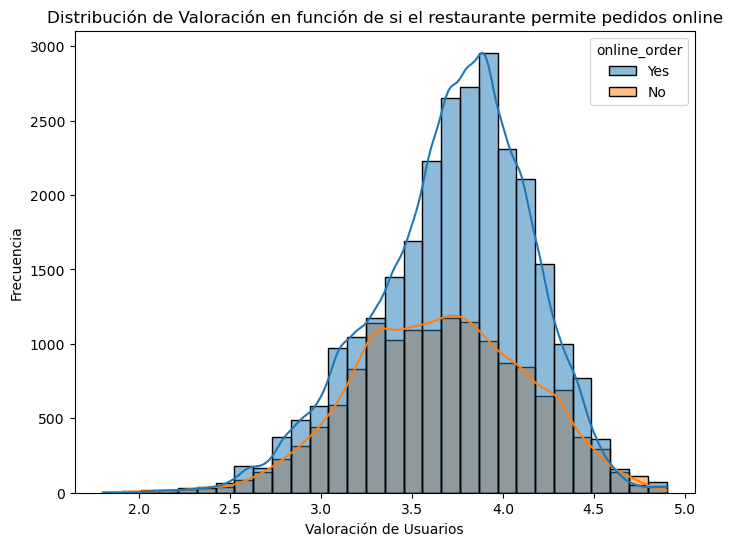

In [155]:
# Creamos un histograma con seaborn
plt.figure(figsize = (8, 6))
sns.histplot(data = data, x = 'rate', hue = 'online_order', kde = True, bins = 30)

# Título y etiquetas
plt.xlabel('Valoración de Usuarios')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valoración en función de si el restaurante permite pedidos online')

plt.show()

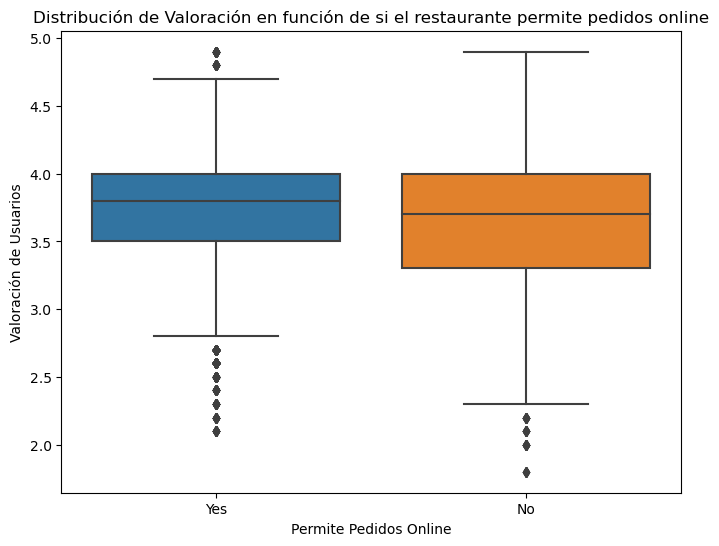

In [156]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='online_order', y='rate', data=data)

plt.xlabel('Permite Pedidos Online')
plt.ylabel('Valoración de Usuarios')
plt.title('Distribución de Valoración en función de si el restaurante permite pedidos online')

plt.show()

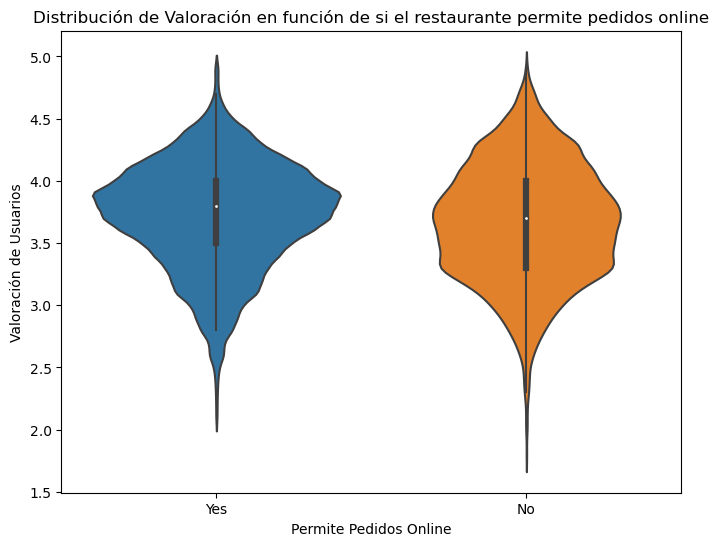

In [157]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=data, x='online_order', y='rate')

plt.xlabel('Permite Pedidos Online')
plt.ylabel('Valoración de Usuarios')
plt.title('Distribución de Valoración en función de si el restaurante permite pedidos online')

plt.show()

## d) Conocer, mediante una visualización, cual es la distribución de la valoracion de los usuarios en función de si el restaurante permite o no reservar mesa.

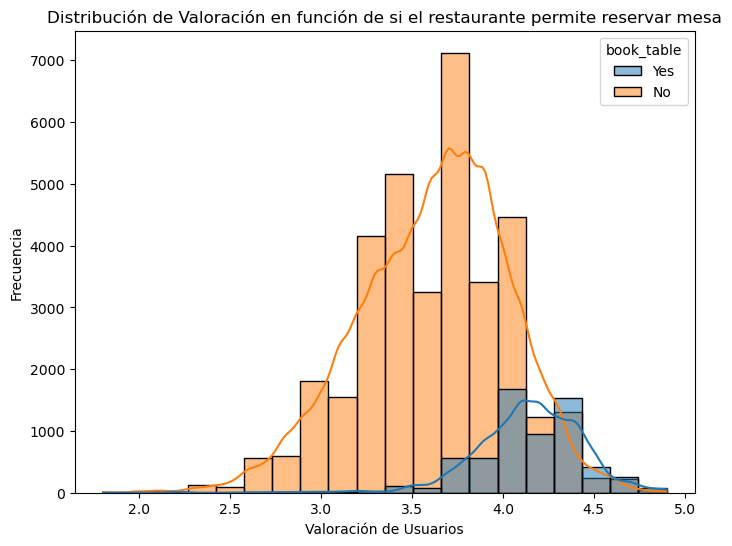

In [158]:
# Creamos un histograma con seaborn
plt.figure(figsize = (8, 6))
sns.histplot(data = data, x = 'rate', hue = 'book_table', kde = True, bins = 20)

# Título y etiquetas
plt.xlabel('Valoración de Usuarios')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valoración en función de si el restaurante permite reservar mesa')

plt.show()

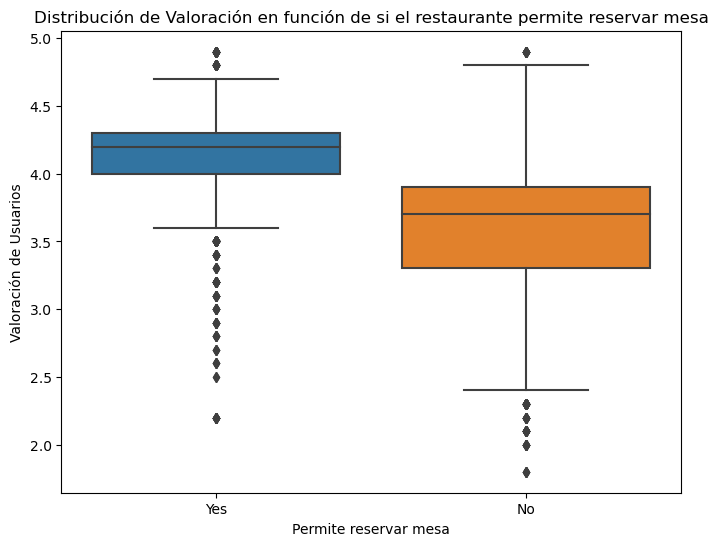

In [159]:
plt.figure(figsize=(8, 6))
sns.boxplot(x= 'book_table', y='rate', data = data)

plt.xlabel('Permite reservar mesa')
plt.ylabel('Valoración de Usuarios')
plt.title('Distribución de Valoración en función de si el restaurante permite reservar mesa')

plt.show()

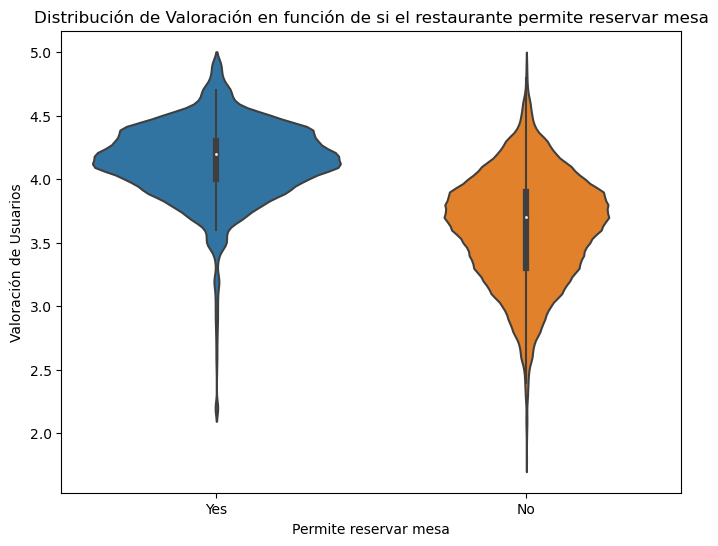

In [160]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=data, x='book_table', y='rate')

plt.xlabel('Permite reservar mesa')
plt.ylabel('Valoración de Usuarios')
plt.title('Distribución de Valoración en función de si el restaurante permite reservar mesa')

plt.show()

## e) ¿Cual de las dos variables analizadas en los apartados d y e crees que sería más determinante de cara a un modelo de Machine Learning? ¿Por qué?

En un primer análisis, creemos que depende de qué objetivo persiguieramos. Si lo que deseamos es centrarnos en la valoración de los usuarios, la varaible `book_table` (permite reservar mesa) podría ser más determinante, ya que esta variable está más relacionada con la experiencia del usuario. 

Por otra parte, si analizamos la distribución de ambas variables, veremos que la variable `book_table` está desbalanceada, por lo que `online_order` podría tener más impacto en el modelo de Machine Learning por su mayor variabilidad.

In [161]:
#Observamos el balanceo de 'book_table'
data['book_table'].value_counts()

No     45268
Yes     6449
Name: book_table, dtype: int64

In [162]:
#Observamos el balanceo de 'online_order'
data['online_order'].value_counts()

Yes    30444
No     21273
Name: online_order, dtype: int64

Visualizamos en un gráfico de barras cómo de desbalanceados están los datos de ambas variables:

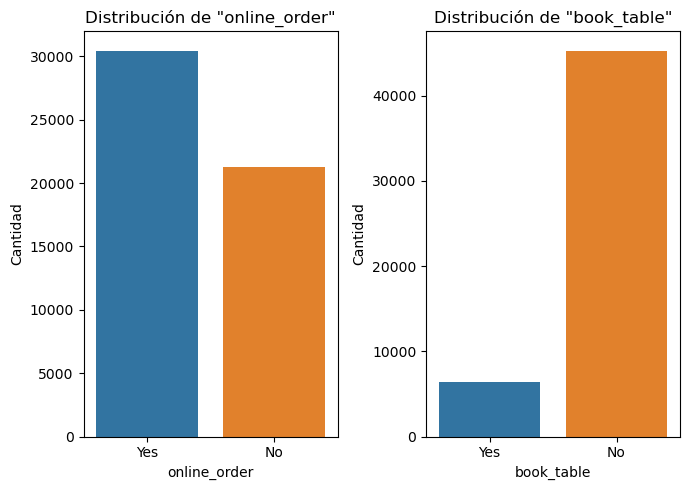

In [163]:
#Creamos figura con dos subplots
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 5))

#Subplot para 'online_order'
sns.countplot(data = data, x = 'online_order', ax = ax[0])
ax[0].set_xlabel('online_order')
ax[0].set_ylabel('Cantidad')
ax[0].set_title('Distribución de "online_order"')

#Subplot para 'book_table'
sns.countplot(data = data, x = 'book_table', ax = ax[1])
ax[1].set_xlabel('book_table')
ax[1].set_ylabel('Cantidad')
ax[1].set_title('Distribución de "book_table"')

plt.tight_layout()
plt.show()


Finalmente, visualizamos la correlación de las variables frente a la variable objetivo `rate`:

In [164]:
#Convertimos el tipo de datos de estas variables para poder visualizarlas
data['online_order'] = data['online_order'].map({'No': 0, 'Yes': 1})
data['book_table'] = data['book_table'].map({'No': 0, 'Yes': 1})

#Eliminamos 'Unnamed: 0'
data.drop('Unnamed: 0', axis = 1, inplace = True)

In [165]:
#Volvemos a dividir train y test, ya que la correlación la hacemos con el dataset que incluye la variable objetivo
train = data.copy()
test = data.copy()

train = train[train["rate"].isna() == False]
test = test[test["rate"].isna() == True]

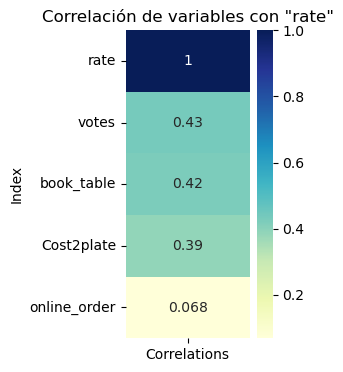

In [166]:
#Realizamos la correlación
corr = train.corrwith(train['rate']).abs().reset_index()
corr.columns = ['Index', 'Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by = ['Correlations'], ascending = False)

plt.figure(figsize = (2, 4))

fig = sns.heatmap(corr, annot = True, fmt = '.2g', cmap = 'YlGnBu')

plt.title('Correlación de variables con "rate"')
plt.show()

**Respuesta**: tanto por razones de negocio como por correlación con la variable objetivo `rate`, sería más determinante para un modelo de Machine Learning la varaible `book_table`.

## f) Realiza las transformaciones que creas necesarias en las variables, explicando cada una de ellas, de cara a crear un modelo de regresión que sea capaz de predecir la valoración de los usuarios.¶

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          51717 non-null  object 
 1   online_order  51717 non-null  int64  
 2   book_table    51717 non-null  int64  
 3   rate          41665 non-null  float64
 4   votes         51717 non-null  int64  
 5   location      51696 non-null  object 
 6   rest_type     51490 non-null  object 
 7   cuisines      51672 non-null  object 
 8   Cost2plate    51371 non-null  float64
 9   Type          51717 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 3.9+ MB


Transformaciones necesarias en las variables:
- `name`: la eliminaremos, no será necearia para el modelo de ML.
- `online_order`: ya la hemos transformado, de tipo string 'Yes' / 'No' a 0 o 1 respectivamente.
- `book_table`: ya la hemos transformado, de tipo string 'Yes' / 'No' a 0 o 1 respectivamente.
- `rate`: ya la hemos transformado, de tipo string XX.X/5 a un `float`, quedándonos con la parte del string a la izquierda de la barra y convirtiendo este string a flotante.
- `votes`: no hace falta transformarla, ya esta en formato `int`.
- `location`: la categorizaremos. Al tener muy pocos valores faltantes, hemos eliminado los registros que tenian valores nan.
- `rest_type`: la categorizaremos. Existen muchos valores repetidos y muchos valores distintosAl tener muy pocos valores faltantes, hemos eliminado los registros que tenian valores nan.
- `cuisines`: la categorizaremos.
- `Cost2plate`: ya está en formato `float`, hemos imputado los valores faltantes por su media.
- `Type`: la categorizaremos

### Variable `name`:

In [168]:
data.drop('name', axis = 1, inplace = True)

### Variable `online_order`:

In [169]:
data['online_order'] = data['online_order'].replace({'No': 0, 'Yes': 1})

### Variable `book_table`:

In [170]:
data['book_table'] = data['book_table'].replace({'No': 0, 'Yes': 1})

### Variable `rate`:

In [171]:
def rate_cleaning(value):
    '''
    Función para convertir el valor tipo string de 'rate' a un valor numérico.
    '''

    value = str(value).split('/')
    value = value[0]
    
    return float(value)

In [172]:
data['rate'] = data['rate'].apply(rate_cleaning)

data['rate'].unique()

array([4.1, 3.8, 3.7, 3.6, 4.6, 4. , 4.2, 3.9, 3.1, 3. , 3.2, 3.3, 2.8,
       4.4, 4.3, nan, 2.9, 3.5, 2.6, 3.4, 4.5, 2.5, 2.7, 4.7, 2.4, 2.2,
       2.3, 4.8, 4.9, 2.1, 2. , 1.8])

### Variable `rest_type`

Objetivo: tener menos categorías. Crear una función que categorice el tipo de restaurante según el texto de `rest_type`.

In [173]:
data.rest_type.unique()

array(['Casual Dining', 'Cafe, Casual Dining', 'Quick Bites',
       'Casual Dining, Cafe', 'Cafe', 'Quick Bites, Cafe',
       'Cafe, Quick Bites', 'Delivery', 'Mess', 'Dessert Parlor',
       'Bakery, Dessert Parlor', 'Pub', 'Bakery', 'Takeaway, Delivery',
       'Fine Dining', 'Beverage Shop', 'Sweet Shop', 'Bar',
       'Beverage Shop, Quick Bites', 'Confectionery',
       'Quick Bites, Beverage Shop', 'Dessert Parlor, Sweet Shop',
       'Bakery, Quick Bites', 'Sweet Shop, Quick Bites', 'Kiosk',
       'Food Truck', 'Quick Bites, Dessert Parlor',
       'Beverage Shop, Dessert Parlor', 'Takeaway', 'Pub, Casual Dining',
       'Casual Dining, Bar', 'Dessert Parlor, Beverage Shop',
       'Quick Bites, Bakery', 'Dessert Parlor, Quick Bites',
       'Microbrewery, Casual Dining', 'Lounge', 'Bar, Casual Dining',
       'Food Court', 'Cafe, Bakery', nan, 'Dhaba',
       'Quick Bites, Sweet Shop', 'Microbrewery',
       'Food Court, Quick Bites', 'Pub, Bar', 'Casual Dining, Pub',
      

In [174]:
rest_type_values = data['rest_type'].value_counts(ascending = False)

rest_type_values[:25]

Quick Bites                   19132
Casual Dining                 10330
Cafe                           3732
Delivery                       2604
Dessert Parlor                 2263
Takeaway, Delivery             2037
Casual Dining, Bar             1154
Bakery                         1141
Beverage Shop                   867
Bar                             697
Food Court                      624
Sweet Shop                      468
Bar, Casual Dining              425
Lounge                          396
Pub                             357
Fine Dining                     346
Casual Dining, Cafe             319
Beverage Shop, Quick Bites      298
Bakery, Quick Bites             289
Mess                            267
Pub, Casual Dining              255
Sweet Shop, Quick Bites         178
Kiosk                           176
Dessert Parlor, Cafe            175
Cafe, Casual Dining             173
Name: rest_type, dtype: int64

In [175]:
rest_type_to_clean = rest_type_values[rest_type_values < 1000]

In [176]:
def cleaning_rest_type(value):
    if value in rest_type_to_clean:
        return 'others'
    else:
        return value

In [177]:
data['rest_type'] = data['rest_type'].apply(cleaning_rest_type)

In [178]:
data['rest_type'].value_counts(ascending = False)

Quick Bites           19132
Casual Dining         10330
others                 9097
Cafe                   3732
Delivery               2604
Dessert Parlor         2263
Takeaway, Delivery     2037
Casual Dining, Bar     1154
Bakery                 1141
Name: rest_type, dtype: int64

In [179]:
data['rest_type'] = data['rest_type'].replace('Casual Dining, Bar', 'Casual Dining')

data['rest_type'].value_counts(ascending = False)

Quick Bites           19132
Casual Dining         11484
others                 9097
Cafe                   3732
Delivery               2604
Dessert Parlor         2263
Takeaway, Delivery     2037
Bakery                 1141
Name: rest_type, dtype: int64

Ahora codificamos en HotEnconding la variable `rest_type`:

In [180]:
rest_type_dummies = pd.get_dummies(data['rest_type'], drop_first = True)

data = pd.concat([data, rest_type_dummies], axis = 1)

data.drop('rest_type', axis = 1, inplace = True)

data.head()

online_order  book_table  rate  votes      location  \
0             1           1   4.1    775  Banashankari   
1             1           0   4.1    787  Banashankari   
2             1           0   3.8    918  Banashankari   
3             0           0   3.7     88  Banashankari   
4             0           0   3.8    166  Basavanagudi   

                         cuisines  Cost2plate    Type  Cafe  Casual Dining  \
0  North Indian, Mughlai, Chinese       800.0  Buffet     0              1   
1     Chinese, North Indian, Thai       800.0  Buffet     0              1   
2          Cafe, Mexican, Italian       800.0  Buffet     0              0   
3      South Indian, North Indian       300.0  Buffet     0              0   
4        North Indian, Rajasthani       600.0  Buffet     0              1   

   Delivery  Dessert Parlor  Quick Bites  Takeaway, Delivery  others  
0         0               0            0                   0       0  
1         0               0            0                   0       0  
2         0               0            0                   0       1  
3         0               0            1                   0       0  
4         0               0            0                   0       0

### Variable `location`:

El objetivo es convertir los strings de texto de la variable `location` a coordenadas, es decir, dos columnas, una con la __latitud__ y otra con la __longitud__.

Vemos que la variable tiene una elevada __cardinalidad__:

In [181]:
data.location.unique()

array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Nagarbhavi', 'Bannerghatta Road', 'BTM', 'Kanakapura Road',
       'Bommanahalli', nan, 'CV Raman Nagar', 'Electronic City', 'HSR',
       'Marathahalli', 'Sarjapur Road', 'Wilson Garden', 'Shanti Nagar',
       'Koramangala 5th Block', 'Koramangala 8th Block', 'Richmond Road',
       'Koramangala 7th Block', 'Jalahalli', 'Koramangala 4th Block',
       'Bellandur', 'Whitefield', 'East Bangalore', 'Old Airport Road',
       'Indiranagar', 'Koramangala 1st Block', 'Frazer Town', 'RT Nagar',
       'MG Road', 'Brigade Road', 'Lavelle Road', 'Church Street',
       'Ulsoor', 'Residency Road', 'Shivajinagar', 'Infantry Road',
       'St. Marks Road', 'Cunningham Road', 'Race Course Road',
       'Commercial Street', 'Vasanth Nagar', 'HBR Layout', 'Domlur',
       'Ejipura', 'Jeevan 

Vamos a representar un gráfico de barras mostrando las localizaciones más habituales:

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='location'>

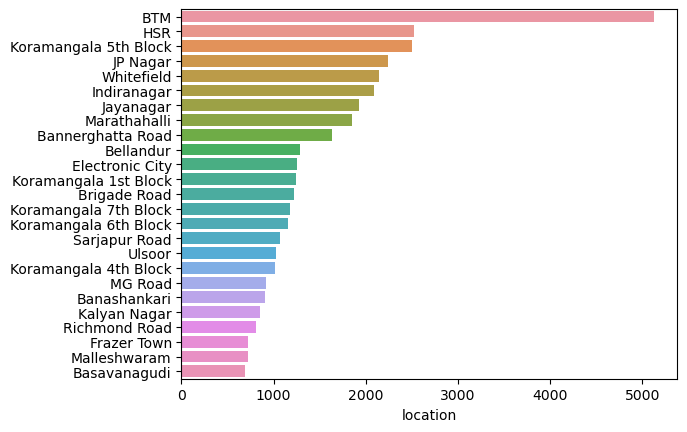

In [182]:
locations_values = data['location'].value_counts()[:25]

sns.barplot(locations_values, locations_values.index)

Creamos un DataFrame que contenga cada una de las localizaciones, luego, usando la librería `geopy`, sacaremos las coordenadas de cada localización y lo añadiremos al dataframe.

In [183]:
locations = pd.DataFrame({'name': data['location'].unique()})
locations.head()

name
0        Banashankari
1        Basavanagudi
2         Mysore Road
3           Jayanagar
4  Kumaraswamy Layout

In [184]:
#!pip install geopy

In [185]:
# Creamos una instancia del geocoder de Nominatim
geolocator = Nominatim(user_agent = 'first_geocoder')

#Obtenemos las coordenadas
lat_lon = []

for location_name in locations['name']:
    location = geolocator.geocode(location_name)
    if location:
        lat_lon.append((location.latitude, location.longitude))
    else:
        lat_lon.append(None)

Vemos el array `lat_lon` que acabamos de crear y luego hacemos que sea una columna del dataframe:

In [186]:
lat_lon[:10]

[(15.8876779, 75.7046777),
 (12.9417261, 77.5755021),
 (12.9467026, 77.5300705),
 (27.3493013, 95.3159407),
 (12.9081487, 77.5553179),
 (12.9274413, 77.5155224),
 (6.9233338, 93.9046149),
 (12.9055682, 77.5455438),
 (12.2655944, 76.6465404),
 (52.49148485, 1.2372484335227272)]

In [187]:
locations['geo_location'] = lat_lon
locations.head()

name              geo_location
0        Banashankari  (15.8876779, 75.7046777)
1        Basavanagudi  (12.9417261, 77.5755021)
2         Mysore Road  (12.9467026, 77.5300705)
3           Jayanagar  (27.3493013, 95.3159407)
4  Kumaraswamy Layout  (12.9081487, 77.5553179)

In [188]:
locations.shape

(94, 2)

In [189]:
rest_locations = pd.DataFrame(data['location'].value_counts().reset_index())
rest_locations.columns = ['name', 'count']
rest_locations.head()

name  count
0                    BTM   5124
1                    HSR   2523
2  Koramangala 5th Block   2504
3               JP Nagar   2235
4             Whitefield   2144

In [190]:
rest_locations.shape

(93, 2)

Unimos los dos dataframes en uno, juntando la información de `count`, con la información de `geo_location`, teniendo en común la variable `name`:

In [191]:
rest_locations = rest_locations.merge(right = locations,
                                      how = 'outer',
                                      on = 'name')
rest_locations.dropna(inplace = True)

rest_locations

name   count  \
0                             BTM  5124.0   
1                             HSR  2523.0   
2           Koramangala 5th Block  2504.0   
3                        JP Nagar  2235.0   
4                      Whitefield  2144.0   
5                     Indiranagar  2083.0   
6                       Jayanagar  1926.0   
7                    Marathahalli  1846.0   
8               Bannerghatta Road  1630.0   
9                       Bellandur  1286.0   
10                Electronic City  1258.0   
11          Koramangala 1st Block  1238.0   
12                   Brigade Road  1218.0   
13          Koramangala 7th Block  1181.0   
14          Koramangala 6th Block  1156.0   
15                  Sarjapur Road  1065.0   
16                         Ulsoor  1023.0   
17          Koramangala 4th Block  1017.0   
18                        MG Road   918.0   
19                   Banashankari   906.0   
20                   Kalyan Nagar   853.0   
21                  Richmond Road   812.0   
22                    Frazer Town   727.0   
23                   Malleshwaram   725.0   
24                   Basavanagudi   684.0   
25                 Residency Road   675.0   
26                      Banaswadi   664.0   
27                    Brookefield   658.0   
28                   New BEL Road   649.0   
29                   Kammanahalli   648.0   
30                    Rajajinagar   591.0   
31                  Church Street   569.0   
32                   Lavelle Road   529.0   
33                   Shanti Nagar   511.0   
34                   Shivajinagar   499.0   
35                         Domlur   496.0   
36                Cunningham Road   491.0   
37               Old Airport Road   446.0   
38                        Ejipura   439.0   
39              Commercial Street   370.0   
40                 St. Marks Road   352.0   
41          Koramangala 8th Block   320.0   
42                  Vasanth Nagar   295.0   
43             Jeevan Bhima Nagar   272.0   
44                  Wilson Garden   246.0   
45                   Bommanahalli   238.0   
46          Koramangala 3rd Block   216.0   
47             Kumaraswamy Layout   195.0   
48                   Thippasandra   194.0   
49             Basaveshwara Nagar   191.0   
50                       Nagawara   187.0   
51                  Seshadripuram   165.0   
52                         Hennur   161.0   
53                       Majestic   155.0   
54                     HBR Layout   153.0   
55                  Infantry Road   151.0   
56               Race Course Road   139.0   
57                    City Market   126.0   
58                    Yeshwantpur   119.0   
59  Varthur Main Road, Whitefield   117.0   
60     ITPL Main Road, Whitefield   113.0   
61                South Bangalore   107.0   
62          Koramangala 2nd Block   102.0   
63                     Hosur Road   102.0   
64                  Kaggadasapura   101.0   
65                 CV Raman Nagar    90.0   
66                    Vijay Nagar    80.0   
67                       RT Nagar    80.0   
68                   Sanjay Nagar    76.0   
69                 Sadashiv Nagar    63.0   
70                 Sahakara Nagar    53.0   
71                    Koramangala    48.0   
72                 East Bangalore    44.0   
73                      Jalahalli    38.0   
74                    Magadi Road    34.0   
76                  Langford Town    27.0   
77                    Sankey Road    27.0   
78                Old Madras Road    22.0   
79                    Mysore Road    22.0   
80                Kanakapura Road    19.0   
81                       KR Puram    18.0   
82                    Uttarahalli    17.0   
83                         Hebbal    14.0   
84                North Bangalore    14.0   
85                        Kengeri     9.0   
86                     Nagarbhavi     9.0   
87              Central Bangalore     8.0   
88                 West Bangalore     6.0   
89                      

In [192]:
rest_locations.shape

(92, 3)

In [193]:
rest_locations[['latitude', 'longitude']] = rest_locations['geo_location'].apply(lambda x: pd.Series({'latitude': x[0], 'longitude': x[1]}))

In [194]:
rest_locations.drop('geo_location', axis = 1, inplace = True)

In [195]:
rest_locations.head()

name   count   latitude   longitude
0                    BTM  5124.0  45.954851 -112.496595
1                    HSR  2523.0  29.152347   75.724580
2  Koramangala 5th Block  2504.0  12.934843   77.618977
3               JP Nagar  2235.0  12.265594   76.646540
4             Whitefield  2144.0  53.553368   -2.296902

In [196]:
#!pip install folium

In [197]:
import folium
from folium.plugins import HeatMap

In [198]:
def genratebasemap(default_location =[12.934843,77.618977],default_zoom_start=12):
    basemap = folium.Map(location= default_location,zoom_start=default_zoom_start)
    return basemap

basemap = genratebasemap()

In [199]:
HeatMap(rest_locations[['latitude','longitude','count']].values.tolist(),zoom=20,radius = 15).add_to(basemap)

In [200]:
basemap

Sacamos un mapa de calor de las zonas con más restaurantes del dataframe:

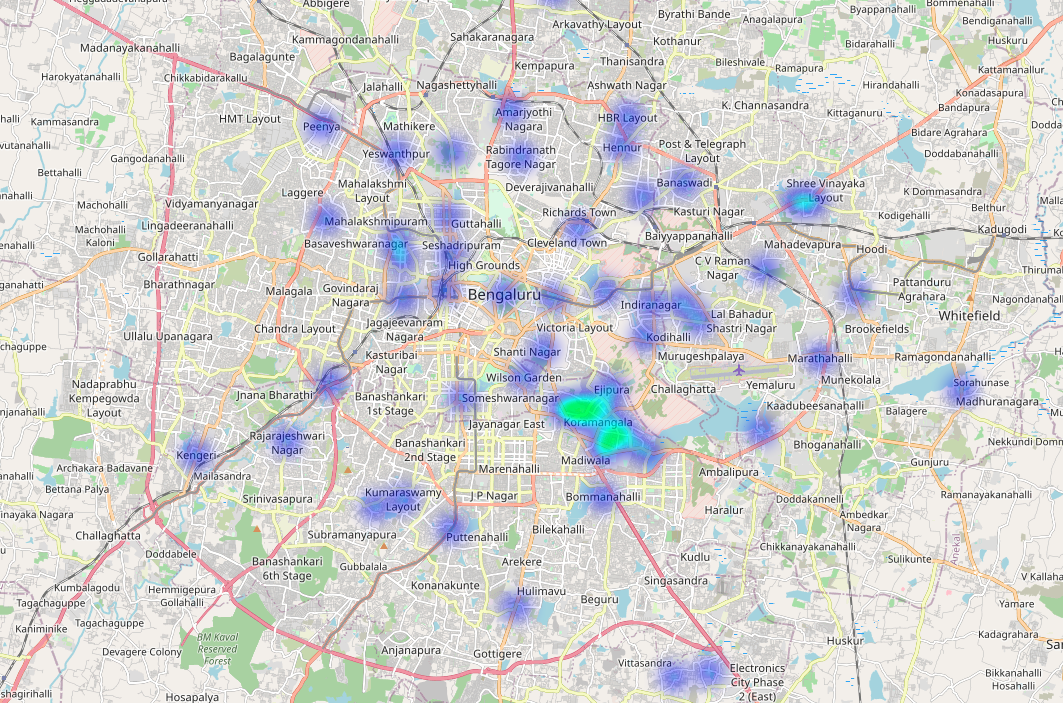

In [201]:
data.head()

online_order  book_table  rate  votes      location  \
0             1           1   4.1    775  Banashankari   
1             1           0   4.1    787  Banashankari   
2             1           0   3.8    918  Banashankari   
3             0           0   3.7     88  Banashankari   
4             0           0   3.8    166  Basavanagudi   

                         cuisines  Cost2plate    Type  Cafe  Casual Dining  \
0  North Indian, Mughlai, Chinese       800.0  Buffet     0              1   
1     Chinese, North Indian, Thai       800.0  Buffet     0              1   
2          Cafe, Mexican, Italian       800.0  Buffet     0              0   
3      South Indian, North Indian       300.0  Buffet     0              0   
4        North Indian, Rajasthani       600.0  Buffet     0              1   

   Delivery  Dessert Parlor  Quick Bites  Takeaway, Delivery  others  
0         0               0            0                   0       0  
1         0               0            0                   0       0  
2         0               0            0                   0       1  
3         0               0            1                   0       0  
4         0               0            0                   0       0

Queremos sustituir la variable `location` del dataframe original por las coordenadas `latitude` y `longitude` del dataframe `rest_locations`.

In [202]:
#Creamos un diccionario con el nombre de las localizaciones y sus coordenadas correspondientes
locations_dict = rest_locations.set_index('name')[['latitude', 'longitude']].to_dict(orient = 'index')

#Ahora mapeamos las coordenadas en el dataframe original usando la columna location. Si el nombre está en el diccionario, lo sustituirá por las coordenadas
data['lat'] = data['location'].map(lambda x: locations_dict[x]['latitude'] if x in locations_dict else None)
data['lon'] = data['location'].map(lambda x: locations_dict[x]['longitude'] if x in locations_dict else None)

data.head()

online_order  book_table  rate  votes      location  \
0             1           1   4.1    775  Banashankari   
1             1           0   4.1    787  Banashankari   
2             1           0   3.8    918  Banashankari   
3             0           0   3.7     88  Banashankari   
4             0           0   3.8    166  Basavanagudi   

                         cuisines  Cost2plate    Type  Cafe  Casual Dining  \
0  North Indian, Mughlai, Chinese       800.0  Buffet     0              1   
1     Chinese, North Indian, Thai       800.0  Buffet     0              1   
2          Cafe, Mexican, Italian       800.0  Buffet     0              0   
3      South Indian, North Indian       300.0  Buffet     0              0   
4        North Indian, Rajasthani       600.0  Buffet     0              1   

   Delivery  Dessert Parlor  Quick Bites  Takeaway, Delivery  others  \
0         0               0            0                   0       0   
1         0               0            0                   0       0   
2         0               0            0                   0       1   
3         0               0            1                   0       0   
4         0               0            0                   0       0   

         lat        lon  
0  15.887678  75.704678  
1  15.887678  75.704678  
2  15.887678  75.704678  
3  15.887678  75.704678  
4  12.941726  77.575502

Observamos que hay una localización que no está en el diccionario. Vemos que son todos los registros de _Rammurthy Nagar_. Añadimos la localización de _Rammurthy Nagar_ (lat = 13.0184435 / lon = 77.67812149999997) al diccionario `locations_dict`y volvemos a aplicar el proceso de imputación:

In [203]:
data[(data['lat'].isna() == True) | (data['lon'].isna() == True)][['location', 'lat', 'lon']]

location  lat  lon
1662               NaN  NaN  NaN
9874               NaN  NaN  NaN
13693              NaN  NaN  NaN
16351              NaN  NaN  NaN
16358  Rammurthy Nagar  NaN  NaN
23993  Rammurthy Nagar  NaN  NaN
24089  Rammurthy Nagar  NaN  NaN
24112  Rammurthy Nagar  NaN  NaN
24124  Rammurthy Nagar  NaN  NaN
24152  Rammurthy Nagar  NaN  NaN
24193  Rammurthy Nagar  NaN  NaN
24226  Rammurthy Nagar  NaN  NaN
24288  Rammurthy Nagar  NaN  NaN
24290  Rammurthy Nagar  NaN  NaN
24318  Rammurthy Nagar  NaN  NaN
24322  Rammurthy Nagar  NaN  NaN
24523  Rammurthy Nagar  NaN  NaN
24567  Rammurthy Nagar  NaN  NaN
25291  Rammurthy Nagar  NaN  NaN
25343  Rammurthy Nagar  NaN  NaN
25345  Rammurthy Nagar  NaN  NaN
25400  Rammurthy Nagar  NaN  NaN
25420  Rammurthy Nagar  NaN  NaN
25427  Rammurthy Nagar  NaN  NaN
25432  Rammurthy Nagar  NaN  NaN
25452  Rammurthy Nagar  NaN  NaN
25455  Rammurthy Nagar  NaN  NaN
25461  Rammurthy Nagar  NaN  NaN
25518  Rammurthy Nagar  NaN  NaN
25521  Rammurthy Nagar  NaN  NaN
25523  Rammurthy Nagar  NaN  NaN
25646  Rammurthy Nagar  NaN  NaN
25658  Rammurthy Nagar  NaN  NaN
25704  Rammurthy Nagar  NaN  NaN
25877  Rammurthy Nagar  NaN  NaN
26432              NaN  NaN  NaN
26519              NaN  NaN  NaN
27672              NaN  NaN  NaN
27999  Rammurthy Nagar  NaN  NaN
28611              NaN  NaN  NaN
29298              NaN  NaN  NaN
30604              NaN  NaN  NaN
31400              NaN  NaN  NaN
32131              NaN  NaN  NaN
33457              NaN  NaN  NaN
34755              NaN  NaN  NaN
40354              NaN  NaN  NaN
40556              NaN  NaN  NaN
41980              NaN  NaN  NaN
46586              NaN  NaN  NaN
46609              NaN  NaN  NaN
46752              NaN  NaN  NaN
47134              NaN  NaN  NaN

In [204]:
#Añadimos al diccionario la nueva entrada
locations_dict['Rammurthy Nagar'] = {'latitude': 13.0184435, 'longitude': 77.67812149999997}

#Volvemos a mapear las coordenadas
data['lat'] = data['location'].map(lambda x: locations_dict[x]['latitude'] if x in locations_dict else None)
data['lon'] = data['location'].map(lambda x: locations_dict[x]['longitude'] if x in locations_dict else None)

#Comprobamos valores faltantes
data[(data['lat'].isna() == True) | (data['lon'].isna() == True)][['location', 'lat', 'lon']]

location  lat  lon
1662       NaN  NaN  NaN
9874       NaN  NaN  NaN
13693      NaN  NaN  NaN
16351      NaN  NaN  NaN
26432      NaN  NaN  NaN
26519      NaN  NaN  NaN
27672      NaN  NaN  NaN
28611      NaN  NaN  NaN
29298      NaN  NaN  NaN
30604      NaN  NaN  NaN
31400      NaN  NaN  NaN
32131      NaN  NaN  NaN
33457      NaN  NaN  NaN
34755      NaN  NaN  NaN
40354      NaN  NaN  NaN
40556      NaN  NaN  NaN
41980      NaN  NaN  NaN
46586      NaN  NaN  NaN
46609      NaN  NaN  NaN
46752      NaN  NaN  NaN
47134      NaN  NaN  NaN

Finalmente, eliminamos la variable `location`:

In [205]:
#Eliminamos la variable location
data.drop('location', axis = 1, inplace = True)

### Variable `cuisines`:

In [206]:
cuisines = data['cuisines'].value_counts(ascending  = False)


cuisines_to_clean = cuisines[cuisines < 500]



def cleaning_cuisines(value):
    if(value in cuisines_to_clean):
        return 'others'
    else:
        return value
        
data['cuisines'] = data['cuisines'].apply(cleaning_cuisines)
data['cuisines'].value_counts()

others                                 38459
North Indian                            2913
North Indian, Chinese                   2385
South Indian                            1828
Biryani                                  918
Bakery, Desserts                         911
Fast Food                                803
Desserts                                 766
Cafe                                     756
South Indian, North Indian, Chinese      726
Bakery                                   651
Chinese                                  556
Name: cuisines, dtype: int64

In [207]:
cuisines_dummies = pd.get_dummies(data['cuisines'], drop_first = True)

In [208]:
data = pd.concat([data, cuisines_dummies], axis = 1)

data.drop('cuisines', axis = 1, inplace = True)

In [209]:
data.head()

online_order  book_table  rate  votes  Cost2plate    Type  Cafe  \
0             1           1   4.1    775       800.0  Buffet     0   
1             1           0   4.1    787       800.0  Buffet     0   
2             1           0   3.8    918       800.0  Buffet     0   
3             0           0   3.7     88       300.0  Buffet     0   
4             0           0   3.8    166       600.0  Buffet     0   

   Casual Dining  Delivery  Dessert Parlor  ...  Biryani  Cafe  Chinese  \
0              1         0               0  ...        0     0        0   
1              1         0               0  ...        0     0        0   
2              0         0               0  ...        0     0        0   
3              0         0               0  ...        0     0        0   
4              1         0               0  ...        0     0        0   

   Desserts  Fast Food  North Indian  North Indian, Chinese  South Indian  \
0         0          0             0                      0             0   
1         0          0             0                      0             0   
2         0          0             0                      0             0   
3         0          0             0                      0             0   
4         0          0             0                      0             0   

   South Indian, North Indian, Chinese  others  
0                                    0       1  
1                                    0       1  
2                                    0       1  
3                                    0       1  
4                                    0       1  

[5 rows x 26 columns]

### Variable `Cost2plate`:

La variable `Cost2plate`ya está en formato `float`. Únicamente imputaremos los valores faltantes por su media:

In [210]:
#Imputa los valores faltantes de 'Cost2plate' por su media
data['Cost2plate'] = data['Cost2plate'].fillna(data['Cost2plate'].mean())

In [211]:
data.Cost2plate.describe()

count    51717.000000
mean       555.431566
std        437.380224
min         40.000000
25%        300.000000
50%        400.000000
75%        650.000000
max       6000.000000
Name: Cost2plate, dtype: float64

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='Cost2plate', ylabel='Density'>

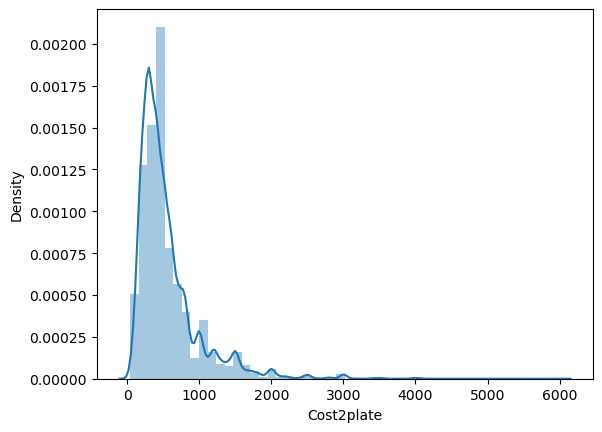

In [212]:
sns.distplot(data['Cost2plate'])

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Cost2plate'>

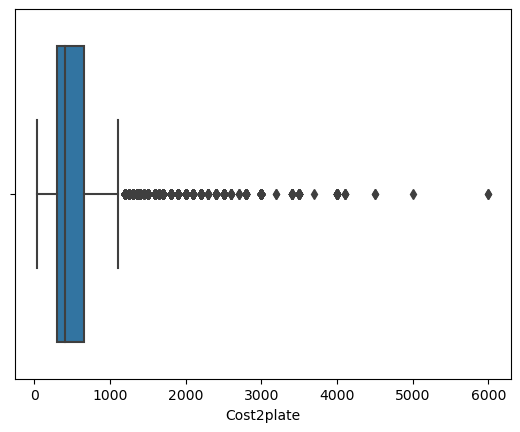

In [213]:
sns.boxplot(data['Cost2plate'])

### Variable `Type`

In [214]:
data['Type'].isna().sum()

0

In [215]:
data['Type'].unique()

array(['Buffet', 'Cafes', 'Delivery', 'Desserts', 'Dine-out',
       'Drinks & nightlife', 'Pubs and bars'], dtype=object)

In [216]:
data.Type.value_counts()

Delivery              25942
Dine-out              17779
Desserts               3593
Cafes                  1723
Drinks & nightlife     1101
Buffet                  882
Pubs and bars           697
Name: Type, dtype: int64

In [217]:
type_dummies = pd.get_dummies(data['Type'], drop_first=True)

In [218]:
# Agrego las nuevas columnas codificadas al DataFrame
data = pd.concat([data, type_dummies], axis=1)

# Elimino la columna original 'Type'
data.drop('Type', axis=1, inplace=True)

In [219]:
data.head()

online_order  book_table  rate  votes  Cost2plate  Cafe  Casual Dining  \
0             1           1   4.1    775       800.0     0              1   
1             1           0   4.1    787       800.0     0              1   
2             1           0   3.8    918       800.0     0              0   
3             0           0   3.7     88       300.0     0              0   
4             0           0   3.8    166       600.0     0              1   

   Delivery  Dessert Parlor  Quick Bites  ...  North Indian, Chinese  \
0         0               0            0  ...                      0   
1         0               0            0  ...                      0   
2         0               0            0  ...                      0   
3         0               0            1  ...                      0   
4         0               0            0  ...                      0   

   South Indian  South Indian, North Indian, Chinese  others  Cafes  Delivery  \
0             0                                    0       1      0         0   
1             0                                    0       1      0         0   
2             0                                    0       1      0         0   
3             0                                    0       1      0         0   
4             0                                    0       1      0         0   

   Desserts  Dine-out  Drinks & nightlife  Pubs and bars  
0         0         0                   0              0  
1         0         0                   0              0  
2         0         0                   0              0  
3         0         0                   0              0  
4         0         0                   0              0  

[5 rows x 31 columns]

## g) Aplicar un modelo de Regresiónpara tratar de predecir la valoración de los usuarios. Trata de mejorar los resultados aplicando otros modelos. (Regresión Lineal Múltiple, Árboles de Regresión o Random Forest Regressor)

## h) Selecciona el mejor modelo basándote en la métrica del RMSE

Vamos a aplicar todos los pasos del proceso de __Machine Learning__:
- [x] **_Data Collection_**: realizado. Ya tenemos los datasets que se nos ha proporcionado.
- [x] **_Data Cleaning_**:
    - [x] Valores faltantes: Hecho, ya no hay valores faltantes
    - [x] Valores outliers: Falta, lo haremos a continuación.
- [x] **_Feature Engineering_**:
    - [x] Variables transformadas a valores numéricos y las categóricas han sido codificadas.
    - [x] Variable `location` transformada a geolocalización.
- [x] **_Model Building for selecting correct ML algorithm_**: a continuación.
- [x] **_Model Evaluation_**: a continuación.
- [x] **_Model Deployment_**: a continuación.

##### Outliers

Los valores atípicos se determinan utilizando el rango intercuartílico (IRQ) y el criterio de 1.5 veces (__atípicos leves__) el IRQ por encima del tercer cuartil (Q3) o por debajo del primer cuartil (Q1). Para los __atípicos graves__ sería 3 veces el IRQ.

Sacamos los valores atípicos para las columnas numéricas:

In [220]:
cols_num = ['rate', 'votes', 'Cost2plate']

print('Datos atípicos leves:')
for col in cols_num:
    value = data[col]
    q1 = value.quantile(0.25)
    q3 = value.quantile(0.75)
    irq = q3 - q1
    outliers = value[(value <= q1 - 1.5 * irq) | (value >= q3 + 1.5 * irq)]
    perc = len(outliers) * 100 / len(data)
    print(f'Variable {col}: {perc:.2f}%.')
      
print()
print('Datos atípicos graves:')
for col in cols_num:
    value = data[col]
    q1 = value.quantile(0.25)
    q3 = value.quantile(0.75)
    irq = q3 - q1
    outliers = value[(value <= q1 - 3 * irq) | (value >= q3 + 3 * irq)]
    perc = len(outliers) * 100 / len(data)
    print(f'Variable {col}: {perc:.2f}%.')    

Datos atípicos leves:
Variable rate: 0.66%.
Variable votes: 13.46%.
Variable Cost2plate: 9.21%.

Datos atípicos graves:
Variable rate: 0.00%.
Variable votes: 9.20%.
Variable Cost2plate: 2.91%.


<AxesSubplot:>

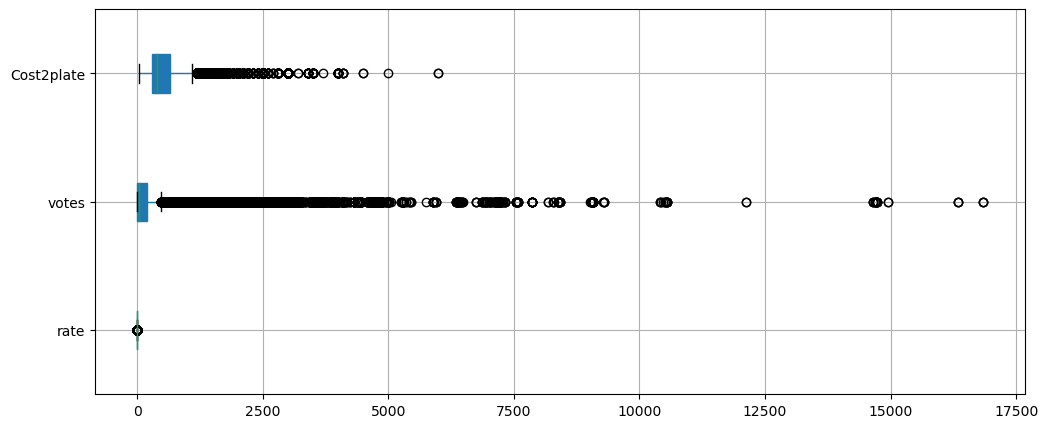

In [221]:
plt.figure(figsize=(12,5))
data[cols_num].boxplot(patch_artist=True,vert=False)

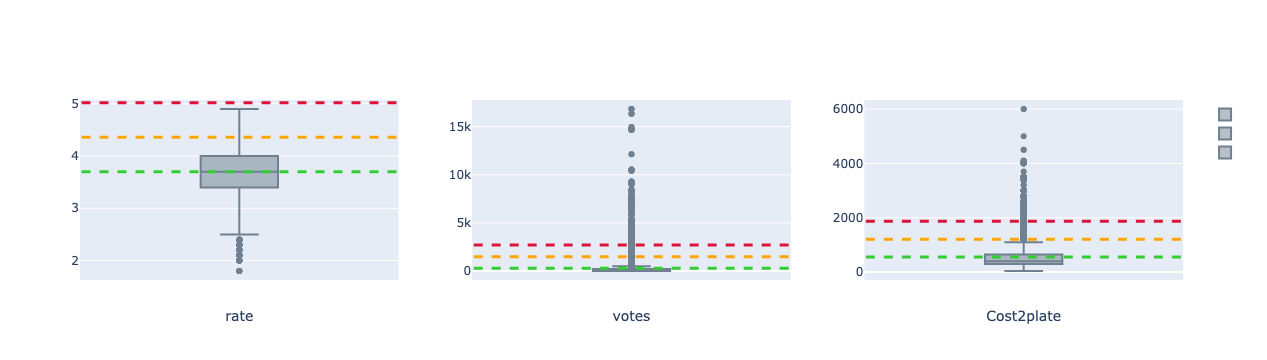

In [222]:
# Crea una serie de plots con 1 row y tantas columnas como tenga el listado
fig = make_subplots(1, len(cols_num))

# Crea un plot por columna y el título debajo por columna
for i, column in enumerate(cols_num):

    # Box plot
    fig.add_trace(
        go.Box(y=data[column], name=' ', marker=dict(color='SlateGray')),
        row=1, col=i+1,) # Position: Row 1, columna según iteración
    fig.update_xaxes(title_text=column, col=i+1) # Agrega un título en el eje x
    
    # Línea de media
    mean = data[column].mean()
    fig.add_shape(
        type='line',
        x0=-1, x1=1, # Width: De izquierda a derecha
        y0=mean, y1=mean, # Height: Media
        line=dict(color='LimeGreen', width=3, dash='dash'), # Styles
        row=1, col=i+1 # Position: Plot iterado
    )

    # Línea de atípicos leves
    low_outliers = mean + 1.5 * data[column].std()
    fig.add_shape(
        type='line',
        x0=-1, x1=1, # Width: De izquierda a derecha
        y0=low_outliers, y1=low_outliers, # Height: Atipicos leves
        line=dict(color='Orange', width=3, dash='dash'), # Styles
        row=1, col=i+1 # Position: Plot iterado
    )
     
    # Línea de atípicos graves
    high_outliers = mean + 3 * data[column].std()
    fig.add_shape(
        type='line',
        x0=-1, x1=1, # Width: De izquierda a derecha
        y0=high_outliers, y1=high_outliers, # Height: Atipicos leves
        line=dict(color='Crimson', width=3, dash='dash'), # Styles
        row=1, col=i+1 # Position: Plot iterado
    )
fig.show()

In [223]:
data[cols_num].describe()

rate         votes    Cost2plate
count  41665.000000  51717.000000  51717.000000
mean       3.700449    283.697527    555.431566
std        0.440513    803.838853    437.380224
min        1.800000      0.000000     40.000000
25%        3.400000      7.000000    300.000000
50%        3.700000     41.000000    400.000000
75%        4.000000    198.000000    650.000000
max        4.900000  16832.000000   6000.000000

**Conclusión sobre outliers**: en las tres variables numéricas no consideramos que existan valores atípicos, a pesar que haya valores que técnicamente se pudieran considerar como tal.
- La variable `rate` es la que tiene una distribución más normalizada. Es entendible que existan varios valores que san bajos(1.8, 2.1, 2.3, etc) ya que son puntuaciones bajas que nos podríamos encontrar en cualquier restaurante que haya tenido clientes insatisfechos, es decir, prácticamente cualquier restaurante en menor o mayor medida. 
- En la variable `votes` tampoco eliminaremos ningún registro, ya qu también es entendible que existan restaurantes que tengan muchas valoraciones, como los más famosos o los más concurridos, y otros que no tengan tantos.
- Respecto a la variable `Cost2plate`, consideramos que tampoco hay valores atípicos, ya que si analizamos los precios de dos platos, es bastante factible que:
    - El registro con `Cost2plate` más bajo sea **40 INR** (rúpias), es decir **0.44 EUR**. Un sitio realmente barato en la India, pero factiblemente posible.
    - El registro con `Cost2plate` más alto sea **6000 INR** (rúpias), es decir **66.34 EUR**, también algo muy realista.

### Preprocesado

Tenemos un dataset con todas las variables categóricas excepto tres:
- `Cost2Plate`
- `votes`
- `rate`

(También tenemos las variables `lat` y `lon` pero no las utilizaremos de momento).

Estas variables deben ser escaladas, ya que cada una está en una escala distinta. Lo haremos todo en un pipeline en el apartado de `Model Building`.

### Matriz de correlaciones y visualización entre variables

In [224]:
#De momento, no tendremos en cuenta la geolocalización
data.drop(['lat', 'lon'], axis = 1, inplace = True)

train = data[data["rate"].isna() == False]
test = data[data["rate"].isna() == True]

test.drop('rate', axis = 1, inplace = True)

/var/folders/cz/j4g3kqwn1c56k2ln51r0lncm0000gn/T/ipykernel_1302/1017906539.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [225]:
print(train.shape)
print(test.shape)

(41665, 29)
(10052, 28)


Comprobamos que no hay valores faltantes:

In [226]:
train.isna().sum().sum()

0

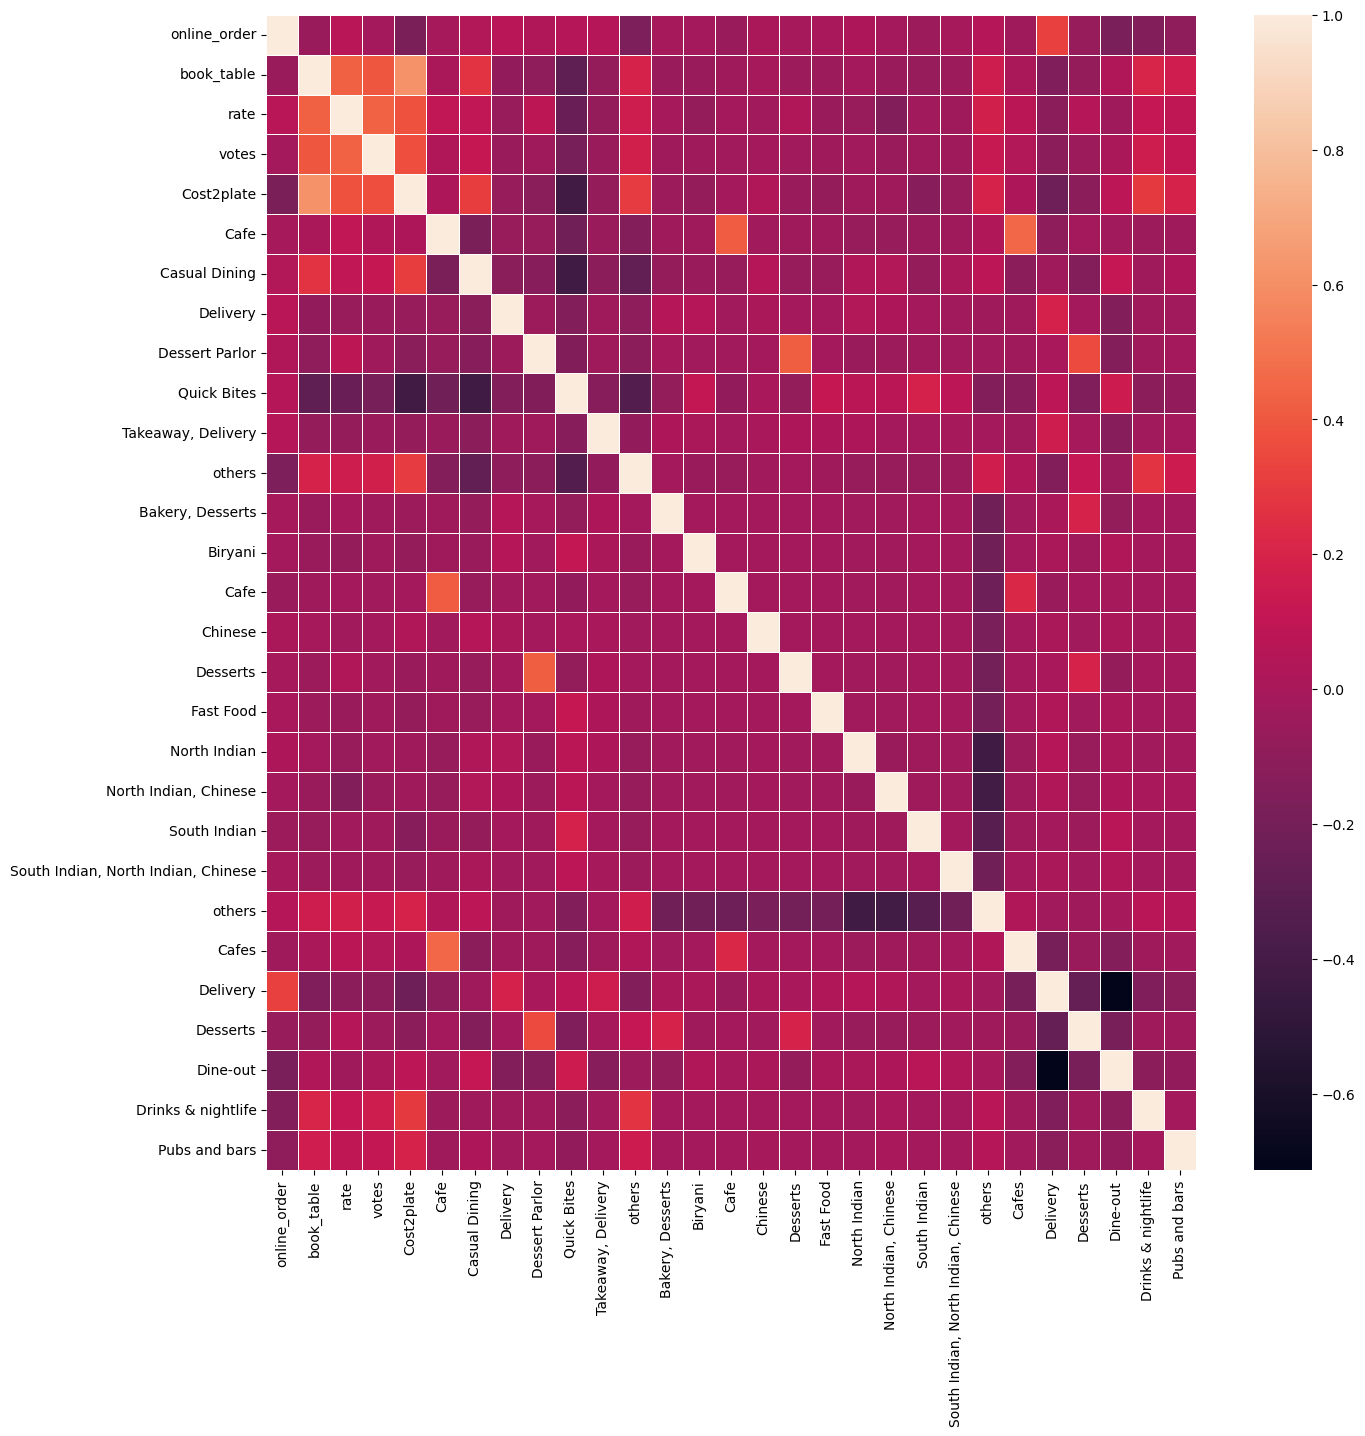

In [227]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(),linewidth=0.5, annot = False)
plt.show()

Nos centraremos en `book_table`, `votes` y `Cost2plate`.

- `book_table` vs `rate`:

Coeficiente de correlación de Pearson Coefficient para la variable votes 0.43404021887197447


(0.0, 7.750596586627803)

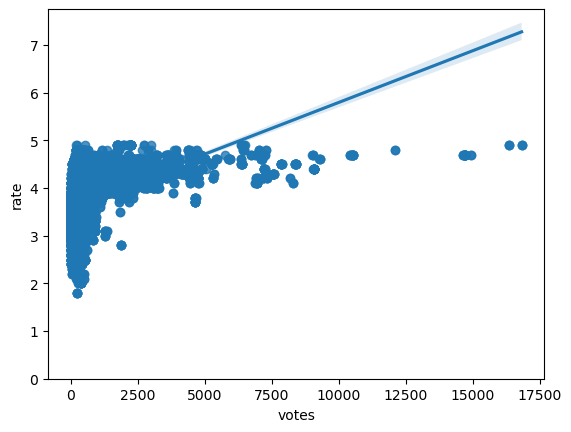

In [228]:
pearson_coef, p_value = stats.pearsonr(train['votes'], train['rate'])
print("Coeficiente de correlación de Pearson Coefficient para la variable votes", pearson_coef)  
sns.regplot(x = "votes", y = "rate", data = train)
plt.ylim(0,)

Coeficiente de correlación de Pearson Coefficient para la variable Cost2plate 0.38411261765365695


(0.0, 5.916719401325239)

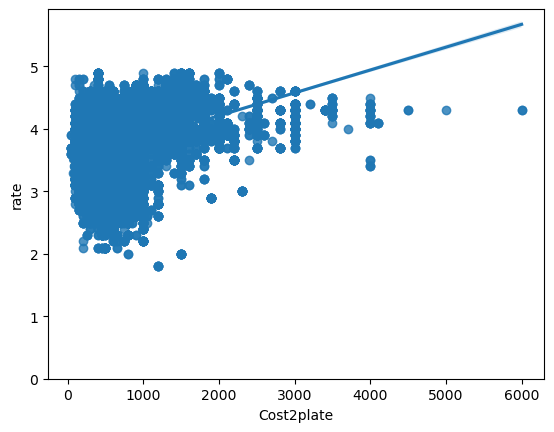

In [229]:
pearson_coef, p_value = stats.pearsonr(train['Cost2plate'], train['rate'])
print("Coeficiente de correlación de Pearson Coefficient para la variable Cost2plate", pearson_coef)  
sns.regplot(x = "Cost2plate", y = "rate", data = train)
plt.ylim(0,)

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='Cost2plate', ylabel='Density'>

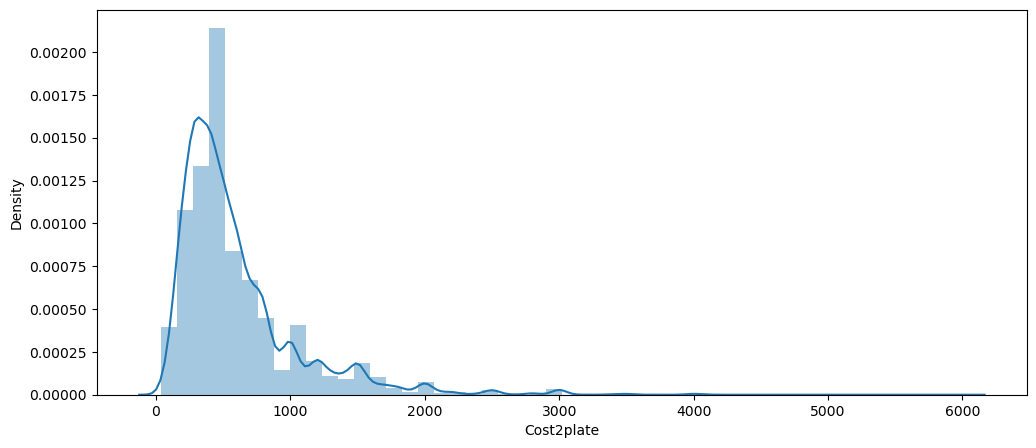

In [230]:
plt.figure(figsize=(12,5))
sns.distplot(train['Cost2plate'])

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='votes', ylabel='Density'>

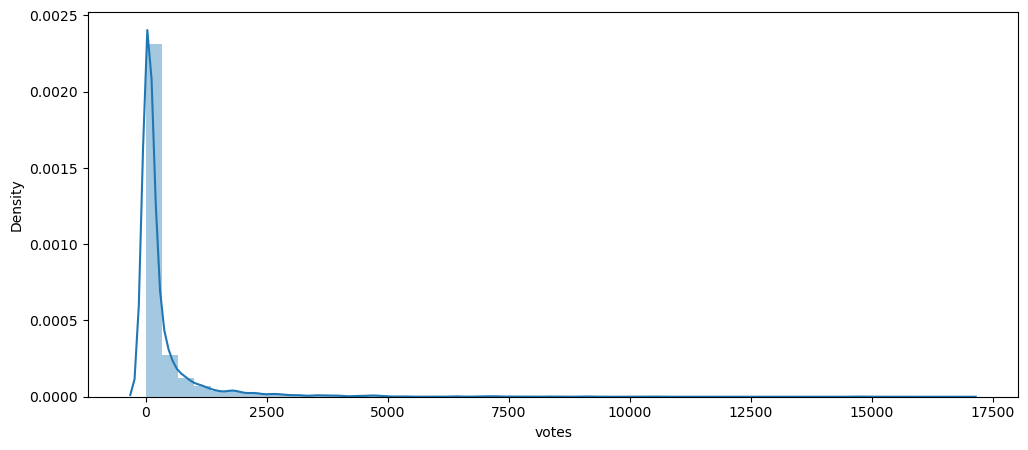

In [231]:
plt.figure(figsize=(12,5))
sns.distplot(train['votes'])

### Definición, entrenamiento y evaluación de modelos

Lo haremos todo en un __pipeline__:
1. **Preprocesador** que **limpie** de valores faltantes y haga las transformaciones que necesitamos.
2. **Escalado de las variables** para que todos los valores estén entre 0 y 1. (MinMaxScaler para las variables numéricas)
3. **Instanciación del modelo y entrenamiento**.
4. **Predicción y evaluación**

Aplicaremos los siguientes modelos:
- `Regresión Lineal Múltiple`
- `Árbol de Regresión`
- `Random Forest Regressor`

Definimos la función de limpieza del dataset, que utilizaremos en el pipeline. La función está compuesta por todas las transformaciones que se pedía en los anteriores apartados:

In [232]:
def cleaning(df):
    '''
    Función para limpiar el DataFrame. 
        - 'name' y 'Unnamed: 0': elimina la variable.
        - 'rate': convierte en float y elimina '/'.
        - 'rest_type': reduce los tipos de restaurante.
        - 'cuisines': reduce los tipos.
        - 'Cost2plate': imputa por la media los valores faltantes.
        - 
    '''   
    #Eliminamos location, hicimos el análisis geográfico previamente
    df.drop('location', axis = 1, inplace = True)
    
    #Convierte 'rate' a float y elimina '/'
    df['rate'] = df['rate'].str.split('/').str[0].astype(float)
    
    #Reduce cardinalidad de 'rest_type', todos los tipos que tengan menos de 1000 los pongo como 'others'
    rest_type_values = df['rest_type'].value_counts(ascending=False)
    rest_type_to_clean = rest_type_values[rest_type_values < 1000]
    df['rest_type'] = df['rest_type'].apply(lambda value: 'others' if value in rest_type_to_clean else value)
    df['rest_type'] = df['rest_type'].replace('Casual Dining, Bar', 'Casual Dining')
    
    #Reduce cardinalidad de 'cuisines', todos los tipos que tengan menos de 500 los pongo como 'others'
    cuisines = df['cuisines'].value_counts(ascending=False)
    cuisines_to_clean = cuisines[cuisines < 500]
    df['cuisines'] = df['cuisines'].apply(lambda value: 'others' if value in cuisines_to_clean else value)
    
    #Imputa los valores faltantes de 'Cost2plate' por su media
    df['Cost2plate'] = df['Cost2plate'].fillna(data['Cost2plate'].mean())
    
    #Elimina registros con Nan en las variables restantes (excepto 'rate')
    df.dropna(subset = ['rest_type', 'cuisines'], inplace=True)
    
    #Guarda los nombres de los restaurantes del dataset de explotación ('test') en una variable
    rest_name_test = df[df['rate'].isna() == True]['name']
    
    #Elimina 'name' y 'Unnamed: 0'
    df.drop(['name', 'Unnamed: 0'], axis = 1, inplace = True)
    
    return df, rest_name_test

### Pipeline: carga, limpieza, preprocesado y evaluación

In [237]:
start_time = time.time()

# Carga del dataset
data = pd.read_csv("./datasets/app_restaurantes_clean.csv")
rest_name = data['name']

# Limpieza de valores faltantes
data_cleaned, rest_name_test = cleaning(data) #aplicamos limpieza al dataset

# Definición de los datasets train y test
train = data_cleaned.copy()
test = data_cleaned.copy()

train = train[train["rate"].isna() == False] # Dataset de construcción
test = test[test["rate"].isna() == True]     # Dataset de explotación

test.drop('rate', axis = 1, inplace = True)

# Definimos las variables numéricas y categóricas automáticamente
num_features = [col for col in train.select_dtypes(include=['number']).columns.tolist() if col != 'rate']
cat_features = [col for col in train.select_dtypes(include=['object']).columns.tolist()]

# Dividimos los datos en conjuntos de entrenamiento y prueba
X = train.drop('rate', axis=1)
y = train['rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Preprocesado (preprocessor): MinMaxScaler (var. numéricas) + OneHotEncoding (var. categóricas)
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers = [
        ('scaler', numeric_transformer, num_features),
        ('onehot', categorical_transformer, cat_features)
    ])

#Instanciación de los modelos

# Pipeline para Multiple Linear Regressor
pipe_mlr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('multiple linear regression', LinearRegression())
                          ])

# Pipeline para Multiple Regression Tree
pipe_rt = Pipeline(steps=[('preprocessor', preprocessor),
                           ('Decision Tree Regressor', DecisionTreeRegressor())
                          ])

# Pipeline para Random Forest Regressor
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('Random Forest Regressor', RandomForestRegressor())
                          ])

# Entrenamiento del pipeline
pipe_mlr.fit(X_train, y_train)  # Multiple Linear Regressor
pipe_rt.fit(X_train, y_train)   # Regression Tree
pipe_rfr.fit(X_train, y_train)  # Random Forest Regressor

# Evaluación de los modelos en el conjunto de prueba
mlr_test_score = pipe_mlr.score(X_test, y_test)
rt_test_score = pipe_rt.score(X_test, y_test)
rfr_test_score = pipe_rfr.score(X_test, y_test)

# Calcula el RMSE para cada modelo
mlr_mse = mean_squared_error(y_test, pipe_mlr.predict(X_test))
mlr_rmse = np.sqrt(mlr_mse)

rt_mse = mean_squared_error(y_test, pipe_rt.predict(X_test))
rt_rmse = np.sqrt(rt_mse)

rfr_mse = mean_squared_error(y_test, pipe_rfr.predict(X_test))
rfr_rmse = np.sqrt(rfr_mse)

# Imprime los resultados
print('Multiple Linear Regressor Test Score: {:.2f}'.format(mlr_test_score))
print('Multiple Linear Regressor RMSE: {:.2f}'.format(mlr_rmse))
print()
print('Regression Tree Test Score: {:.2f}'.format(rt_test_score))
print('Regression Tree RMSE: {:.2f}'.format(rt_rmse))
print()
print('Random Forest Regressor Test Score: {:.2f}'.format(rfr_test_score))
print('Random Forest Regressor RMSE: {:.2f}'.format(rfr_rmse))
print()

# Registra el tiempo de finalización
end_time = time.time()

# Calcula la diferencia de tiempo
execution_time = round((end_time - start_time), 2)

# Imprime el tiempo de ejecución en segundos
print(f'Tiempo de ejecución: {execution_time} segundos')

Multiple Linear Regressor Test Score: 0.34
Multiple Linear Regressor RMSE: 0.36

Regression Tree Test Score: 0.75
Regression Tree RMSE: 0.22

Random Forest Regressor Test Score: 0.81
Random Forest Regressor RMSE: 0.19

Tiempo de ejecución: 47.95 segundos


__Random Forest Regressor Test Score (R^2)__: Un valor de 0.81 para __R^2__ indica que el modelo de __Random Forest__ está explicando aproximadamente el 81% de la variabilidad en los datos de prueba. Esto es positivo y sugiere que el modelo tiene un buen ajuste a los datos.

__Random Forest Regressor RMSE__: Un valor de 0.19 para el __RMSE__ significa que, en promedio, las predicciones del modelo tienen un error de 0.19 unidades con respecto a los valores reales. Un RMSE bajo es deseable, ya que indica que el modelo está haciendo predicciones precisas.

#### XG Boost y ADA Boost con ajuste de hiperparámetros

Probamos otros modelos, esta vez intentando encontrar los mejores hiperparámetros para `XGBoost` y `ADA Boost`:

In [243]:
from sklearn.ensemble import AdaBoostRegressor

In [245]:
# Definimos el preprocesador y el objeto XGBoost
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', Pipeline([('scaler', MinMaxScaler())]), ['votes', 'Cost2plate']),
        ('onehot', Pipeline([('onehot', OneHotEncoder())]), ['online_order', 'book_table', 'rest_type', 'cuisines', 'Type'])
    ])

xgb_estimator = XGBRFRegressor()
adaboost_estimator = AdaBoostRegressor()

# Creaamos el pipeline
pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('XGBoost', xgb_estimator)
])

pipe_ada = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('AdaBoost', AdaBoostRegressor())
])

# Definimos el grid de hiperparámetros
xgb_param_grid = {
    'XGBoost__n_estimators': [100, 200, 300],
    'XGBoost__max_depth': [3, 4, 5]
}

ada_param_grid = {
    'AdaBoost__n_estimators': [50, 100, 200],
    'AdaBoost__learning_rate': [0.01, 0.1, 1.0]
}

# Creamos el objeto GridSearchCV
grid_search_xgb = GridSearchCV(pipe_xgb, xgb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ada = GridSearchCV(pipe_ada, ada_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Entrenamos el objeto GridSearchCV
grid_search_xgb.fit(X_train, y_train)
grid_search_ada.fit(X_train, y_train)

# Obtenemos los mejores parámetros
best_xgb_model = grid_search_xgb.best_estimator_
best_ada_model = grid_search_ada.best_estimator_

best_xgb_params = grid_search_xgb.best_params_
best_ada_params = grid_search_ada.best_params_

# Evaluamos el modelo respecto al conjunto de test
xgb_test_score = best_xgb_model.score(X_test, y_test)
ada_test_score = best_ada_model.score(X_test, y_test)
xgb_mse = mean_squared_error(y_test, best_xgb_model.predict(X_test))
ada_mse = mean_squared_error(y_test, best_ada_model.predict(X_test))
xgb_rmse = np.sqrt(xgb_mse)
ada_rmse = np.sqrt(ada_mse)

print('XGBoost Best Hyperparameters:', best_xgb_params)
print('XGBoost Best Test Score: {:.2f}'.format(xgb_test_score))
print('XGBoost RMSE of the Best Model: {:.2f}'.format(xgb_rmse))
print()
print('AdaBoost Best Hyperparameters:', best_ada_params)
print('AdaBoost Best Test Score: {:.2f}'.format(ada_test_score))
print('AdaBoost RMSE of the Best Model: {:.2f}'.format(ada_rmse))

XGBoost Best Hyperparameters: {'XGBoost__max_depth': 5, 'XGBoost__n_estimators': 100}
XGBoost Best Test Score: 0.47
XGBoost RMSE of the Best Model: 0.32

AdaBoost Best Hyperparameters: {'AdaBoost__learning_rate': 0.01, 'AdaBoost__n_estimators': 200}
AdaBoost Best Test Score: 0.43
AdaBoost RMSE of the Best Model: 0.33


Observamos que sigue siendo mejor `Random Forest Regressor`.

### Predicción y despliegue del modelo

Vemos que el modelo más eficaz es `Random Forest`. Ahora, en lugar de predecir sobre `X_test` como hicimos en la evaluación, lo haremos sobre el dataset de explotación (`test`). Recordemos que `X_test` forma parte de `train`, dataset con el cual hemos entrenado el modelo.

In [246]:
predictions_rfr = pipe_rfr.predict(test)

# Creamos un DataFrame con las predicciones
df_predictions = pd.DataFrame({
    'name': rest_name_test,
    'rate': predictions_rfr
})

df_predictions.head()

name      rate
72          Spicy Tandoor  3.637167
75  Om Sri Vinayaka Chats  3.846000
84              Chill Out  3.626500
90         Me And My Cake  3.740000
91                Sunsadm  3.732000

Mostramos los 10 mejores y 10 peores restaurantes en función de su valoración predicha:

In [247]:
print('Los 10 restaurantes con mejores valoraciones \n', df_predictions.sort_values(by = 'rate', ascending = False)[:10])
print()
print('Los 10 restaurantes con peores valoraciones \n', df_predictions.sort_values(by = 'rate', ascending = True)[:10])

Los 10 restaurantes con mejores valoraciones 
                                      name      rate
21037              Shivaji Military Hotel  4.439000
21290     3B's - Buddies, Bar & Barbecues  4.400000
21281                   Deja Vu Resto Bar  4.400000
21047                             Toscano  4.339000
21280        Levitate Brewery and Kitchen  4.323917
21045                 Once Upon a Rooftop  4.309000
21072               Prems Graama Bhojanam  4.289000
21299  The Coastal Crew by Fujian on 24th  4.223000
21329                        Cafe Shuffle  4.182000
21288                            Kesariya  4.177000

Los 10 restaurantes con peores valoraciones 
                    name      rate
21668   Yummerica Fries  3.203500
21682  Chilli N Chicken  3.222651
21448        Eat N Pack  3.232818
21271     Rustic Treats  3.234771
21605       Mini Forest  3.246650
21654  SLV Kabab Centre  3.258357
21635      Foodies Club  3.258357
21259          Dadaba's  3.263088
21261       Fahad Hotel  3.2

Mostramos las valoraciones predichas en un histograma:

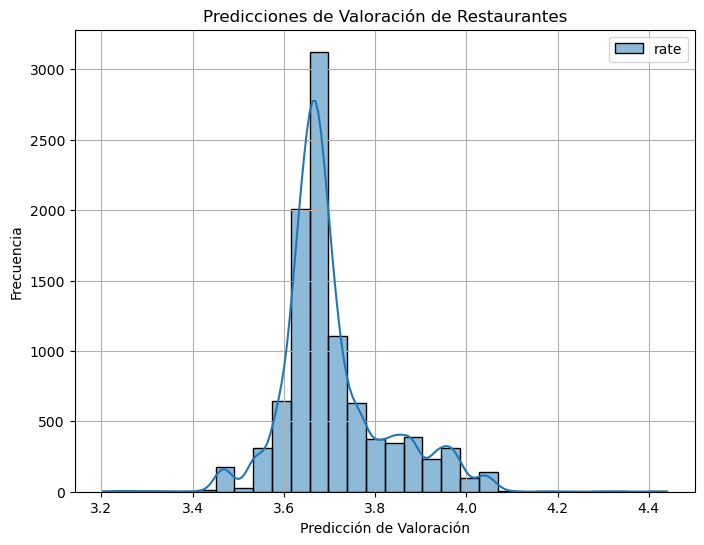

In [248]:
# Histograma
plt.figure(figsize = (8, 6))
sns.histplot(df_predictions, bins = 30, kde=True)
plt.xlabel('Predicción de Valoración')
plt.ylabel('Frecuencia')
plt.title('Predicciones de Valoración de Restaurantes')
plt.grid(True)
plt.show()

Finalmente, guardamos las valoraciones de los restaurantes que se nos encargó predecir en un archivo `csv`:

In [249]:
df_predictions.to_csv('predicciones.csv', index=True)

Vemos como se nos crea en local un __archivo CSV__, en la ruta que especifiquemos cada restaurante con su valoración predicha correspondiente:

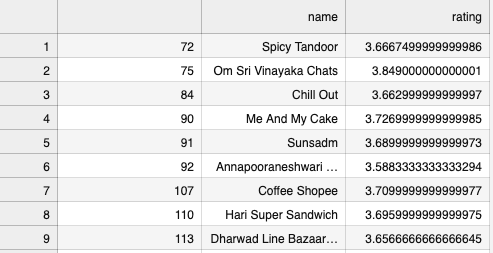

/ / / FIN DE EJERCICIO / / /